In [3]:
#Dont change anything here
import numpy as np
from keras.callbacks import ModelCheckpoint
import keras
from keras import models
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import LoadDataset as LD


class GeneralModel(object):
    
    def __init__(self):
        pass
    
    def set_parameters(self, batch_size = 128, epoch = 100):
        self.batch_size = batch_size
        self.epoch = epoch
        
    def set_training_data (self, X_train,x_height, x_width,channel, Y_train, num_class = 10):# give data in numpy and y in onehot 
        self.X_train = X_train
        self.Y_train = Y_train
        self.num_class = num_class
        self.x_height = x_height
        self.x_width = x_width
        self.channel = channel
        
    def set_test_data (self, X_test, Y_test):
        self.Y_test = Y_test
        self.X_test = X_test
        
    def get_standard_model(self, numb_1st_layer_kernam = 96, number_other_lyer_kernal = 30):
        model = Sequential()
        # model.add(Conv2D(10, (11,11), strides=(4,4), activation='relu', padding='valid', input_shape=(img_height, img_width, channel,)))
        # for original Alexnet
        model.add(Conv2D(numb_1st_layer_kernam, (11,11), strides=(4,4), padding='same', input_shape=(self.x_height, self.x_width, self.channel,)))
        convout1 = Activation('relu')
        model.add(convout1)
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
        model.add(BatchNormalization())
        # Local Response normalization for Original Alexnet
        model.add(Conv2D(30, (3,3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(30, (3,3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(30, (3,3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(30, (3,3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(30, (3,3), activation='relu', padding='same'))
        #model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
        # Local Response normalization for Original Alexnet
        model.add(BatchNormalization())

        model.add(Flatten())
        model.add(Dense(400, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(400, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(self.num_class, activation='softmax'))
        model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

        
        return model
    
    def set_chekpointer(self, checkpointer):
        self.checkpointer = checkpointer
        
    def model_fit(self, model):
        self.model = model
        self.history = self.model.fit(self.X_train, self.Y_train,
                              batch_size = self.batch_size,
                              epochs=self.epoch,
                              callbacks=self.checkpointer,
                              verbose=1,
                              validation_data = (self.X_test, self.Y_test))

        return self.model
    
    def get_history (self):
        return self.history
    def plot_accuracy(self, directory):
        plt.plot(self.history.history['acc'])
        plt.plot(self.history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.savefig(directory)
        
    def plot_loss(self, directory):
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.savefig(directory)
        
    def model_evaluate(self):
        self.score = self.model.evaluate(self.X_test, self.Y_test, verbose=0)
        return self.score
    
    

In [2]:
#Generate a model instance 
import os
maintask_path = 'Maintask_latest/'

if not os.path.exists(maintask_path):
    os.makedirs(maintask_path)
    
    
mymodel = GeneralModel()
#set parameters 
mymodel.set_parameters(batch_size =128,epoch = 60)
num_classes  = 10
#give training and test data 
load_data = LD.LoadData('/netscratch/data/state_farm/imgs/train') # give the directory address.
X = np.load('X.npy')
Y = np.load('Y.npy')
X ,Y = load_data.shuffle_data(X,Y)
X ,Y = load_data.shuffle_data(X,Y)

X.shape


Dataset directory added
['c6', 'c4', 'c5', 'c8', 'c1', 'c0', 'c7', 'c3', 'c9', 'c2']


(22424, 227, 227, 3)

In [23]:
maintask_path = 'Maintask_latest_400_neurons/'
(x_train, y_train) = (X[0:18000], Y[0:18000])
(x_test, y_test) = (X[18000:], Y[18000:])
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]
print(img_height, img_width, channel)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_train.shape)

#set_training_data (self, X_train,x_height, x_width,channel, Y_train, num_class = 10)
mymodel.set_training_data(x_train,img_height,img_width,channel,y_train,num_classes)
mymodel.set_test_data (x_test, y_test)



best_weight_path = maintask_path+"best_weights.hdf5"

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=0, mode='auto')
    
checkpointer = ModelCheckpoint(filepath=best_weight_path,
                               monitor='val_acc',
                               verbose=1,
                               save_best_only= True)
mymodel.set_chekpointer([checkpointer,early_stopping])

model = mymodel.get_standard_model()
#kernal vizualization before training 
model = mymodel.model_fit(model)
#'vizualize(self,layer_num, num_kernel,gray=False, gaus_filter=True,sigma = 1,shapeofgrid=(16,8) ):

path_val_acc = maintask_path + "val_acc.png"
losspath = maintask_path + "val_loss.png"
#mymodel.plot_accuracy(path_val_acc)
#print(history.history.keys())
# summarize history for accuracy








227 227 3
(18000, 10)
Train on 18000 samples, validate on 4424 samples
Epoch 1/60
18000/18000 [==============================] - 39s 2ms/step - loss: 0.5716 - acc: 0.8140 - val_loss: 0.1599 - val_acc: 0.9577

Epoch 00001: val_acc improved from -inf to 0.95773, saving model to Maintask_latest_400_neurons/best_weights.hdf5
Epoch 2/60
18000/18000 [==============================] - 36s 2ms/step - loss: 0.1180 - acc: 0.9643 - val_loss: 0.1202 - val_acc: 0.9645

Epoch 00002: val_acc improved from 0.95773 to 0.96451, saving model to Maintask_latest_400_neurons/best_weights.hdf5
Epoch 3/60
18000/18000 [==============================] - 36s 2ms/step - loss: 0.0835 - acc: 0.9743 - val_loss: 0.0768 - val_acc: 0.9797

Epoch 00003: val_acc improved from 0.96451 to 0.97966, saving model to Maintask_latest_400_neurons/best_weights.hdf5
Epoch 4/60
18000/18000 [==============================] - 35s 2ms/step - loss: 0.0693 - acc: 0.9821 - val_loss: 0.0589 - val_acc: 0.9858

Epoch 00004: val_acc improved

KeyboardInterrupt: 

6


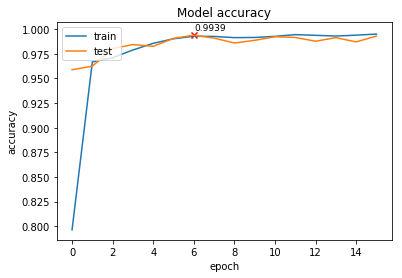

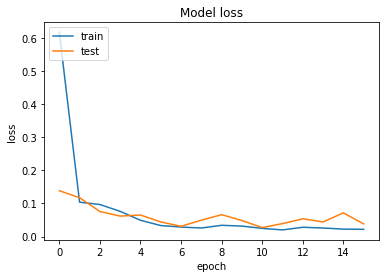

In [20]:

plt.plot(mymodel.history.history['acc'])
plt.plot(mymodel.history.history['val_acc'])


val_list = mymodel.history.history['val_acc']
max_val = max(val_list)
max_index = val_list.index(max(val_list))
print(val_list.index(max(val_list)))

plt.scatter(max_index, max_val, marker='x', color='red')
plt.text(max_index+.03, max_val+.005, round(max_val,4), fontsize=9)


plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path_val_acc)
plt.show()
# summarize history for loss
plt.plot(mymodel.history.history['loss'])
plt.plot(mymodel.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(losspath)
plt.show()

In [9]:
model =  load_model(best_weight_path)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.024775614800931545
Test accuracy: 0.9938969258589512


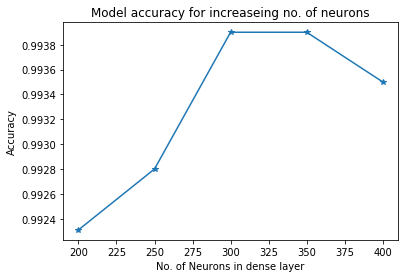

In [32]:
new_list = [0.99231, 0.9928, 0.9939, 0.9939, 0.9935]
ll = [200, 250, 300, 350, 400]
# plt.xlim(200,400,.5)
plt.plot(ll, new_list, '-*')
plt.title('Model accuracy for increaseing no. of neurons')
plt.ylabel('Accuracy')
plt.xlabel('No. of Neurons in dense layer')
plt.savefig('Results/Subtask1/val_acc_for_increasing neurons.png')
plt.show()

In [1]:
import numpy as np
from keras.callbacks import ModelCheckpoint
import keras
from keras import models
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import LoadDataset as LD
num_classes  = 10
#give training and test data 
load_data = LD.LoadData('/netscratch/data/state_farm/imgs/train') # give the directory address.
X = np.load('X.npy')
Y = np.load('Y.npy')
X ,Y = load_data.shuffle_data(X,Y)
X ,Y = load_data.shuffle_data(X,Y)

X.shape

(x_train, y_train) = (X[0:18000], Y[0:18000])
(x_test, y_test) = (X[18000:], Y[18000:])
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Using TensorFlow backend.


Dataset directory added
['c6', 'c4', 'c5', 'c8', 'c1', 'c0', 'c7', 'c3', 'c9', 'c2']


In [2]:
final_model =  load_model('Maintask_latest/best_weights.hdf5')
final_score = final_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', final_score[0])
print('Test accuracy:', final_score[1])

Test loss: 0.009276605030689843
Test accuracy: 0.9975135623869801


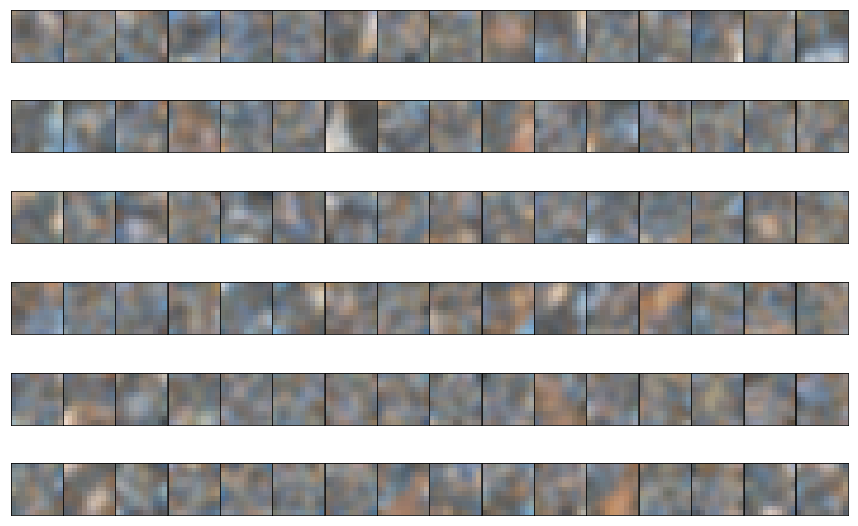

In [3]:
import DataViz as dv
keranl_vix =  dv.DataVizulaize(final_model)
#for layer in model.layers:
#   weights = layer.get_weights() # list of numpy arrays
vizul = keranl_vix.vizualize(0,96, shapeofgrid = (6,16),gray=False)


In [44]:


from keras.models import Model
layer_outputs = [layer.output for layer in final_model.layers]
activation_model = Model(inputs=final_model.input, outputs=layer_outputs)
activations = activation_model.predict(x_test[10].reshape(1,227,227,3))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*1,col_size*1))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='viridis')
            activation_index += 1
        
        
      



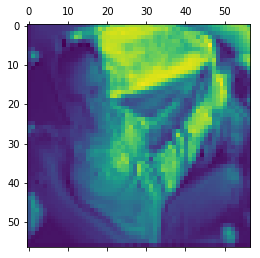

In [42]:

first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

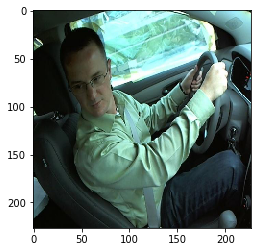

In [27]:
plt.imshow(x_test[10])

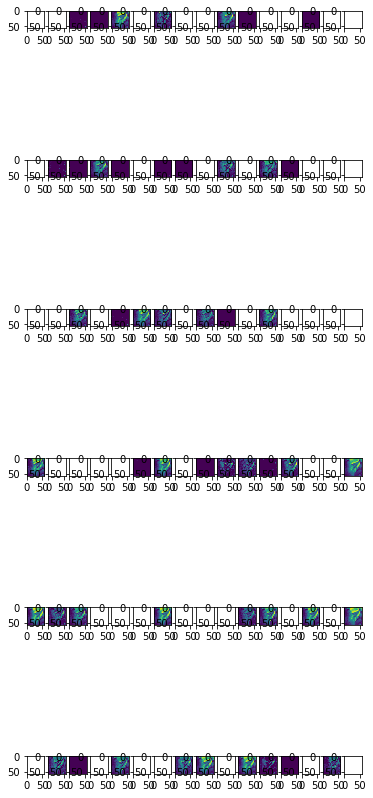

In [64]:
display_activation(activations, 16, 6, 1)

MemoryError: 

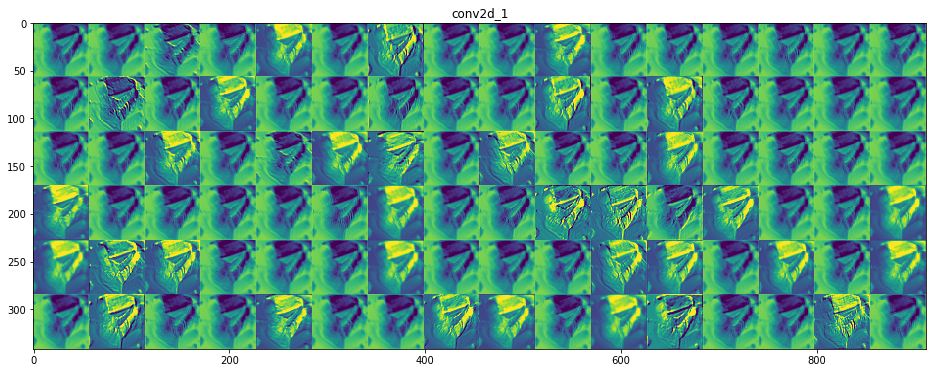

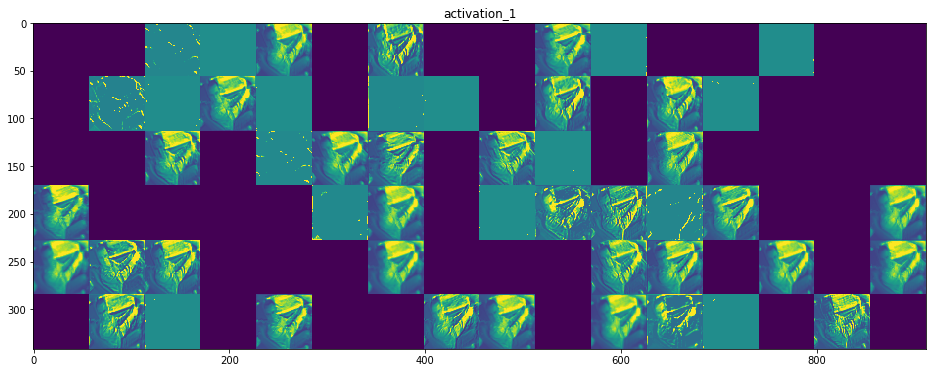

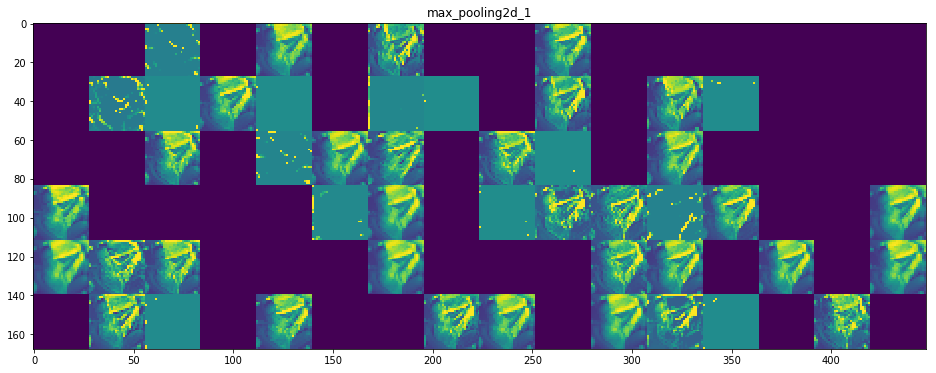

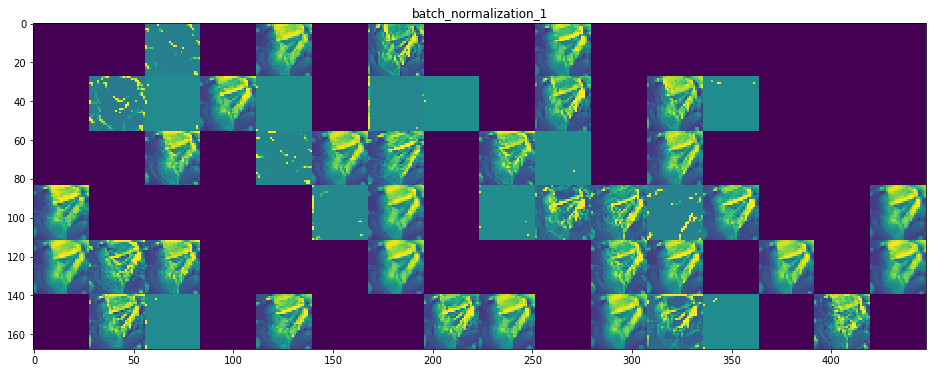

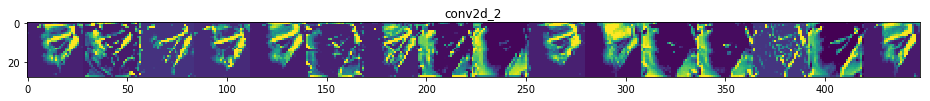

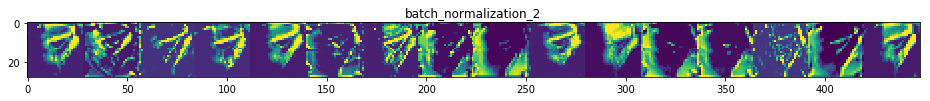

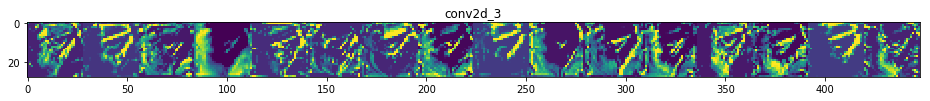

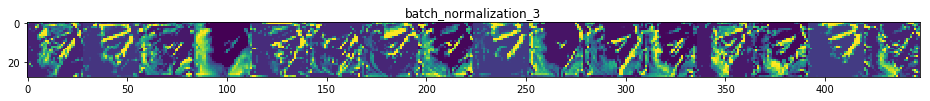

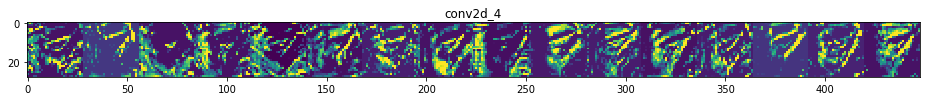

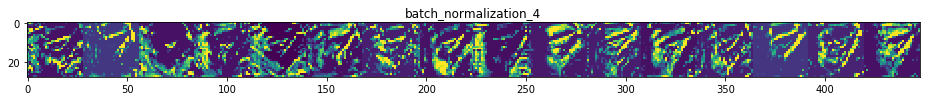

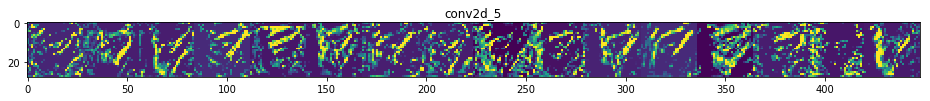

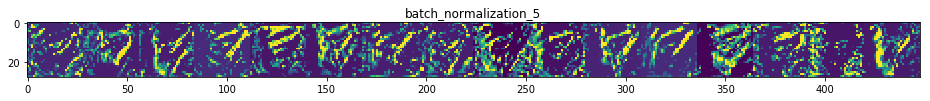

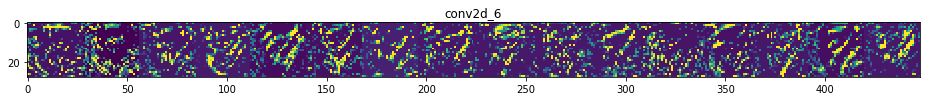

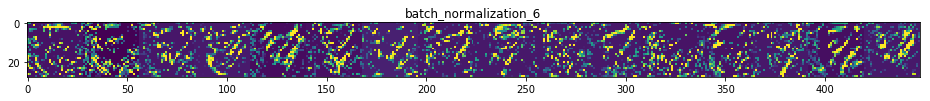

In [67]:
layer_names = []
for layer in final_model.layers[:15]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.savefig("Maintask_latest/" + str(layer_name) + '.png')
    plt.imshow(display_grid, aspect='auto', cmap='viridis')